In [132]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [133]:
import sys
sys.path.insert(0, '..')
from lattice_afi import lattice_2d
from krylov_trotter_circuits import HeavyHexHeisenbergKrylovTNSim
import numpy as np
from scipy.sparse import kron as spkron
from scipy.sparse.linalg import expm as sp_expm
from scipy.linalg import toeplitz
from krylov_ED.ED_Kylov_trotter import solve_regularized_gen_eig

## Small system example

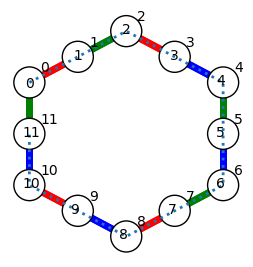

In [134]:
mps_order = np.arange(12)
lat = lattice_2d(nx=1,ny=1, mps_order=mps_order) 
lat.draw(show_gates=True, show_mps_order=True, enumerate_qubits=True)

In [135]:
dt = 0.1
trotter_order = 2
krylov_dim = 5

J = 1.0
g = 1.0

particle_inds = [0,2,4]

In [136]:
circ = HeavyHexHeisenbergKrylovTNSim(lat.nx, lat.ny, chi_max=64, J=J, g=g, mps_order=mps_order) #change lat.nx and lat.ny appropriately. chi_max is maximum bond dimension
circ.initialize_state(flip_inds=particle_inds) #lattice site indices to populate with a particle
S_tn = circ.krylov_S(krylov_dim=krylov_dim, dt=dt, trotter_order=trotter_order) #defaults
H_tn = circ.krylov_H(krylov_dim=krylov_dim, dt=dt, trotter_order=trotter_order)

In [137]:
assert np.isclose(H_tn,H_tn.conj().T).all() and np.isclose(S_tn,S_tn.conj().T).all() #check Hermiticity

In [138]:
evals_tn = solve_regularized_gen_eig(H_tn, S_tn, threshold=1e-8)
print(evals_tn)

[-5.67702848]


## Benchmark against Exact Diagonalization

In [139]:
#Initialize state

zero, one = np.array([1,0]), np.array([0,1])
X,Y,Z,I= np.array([[0,1],[1,0]]), np.array([[0,-1j],[1j,0]]), np.array([[1,0],[0,-1]]), np.eye(2)
H = np.sqrt(1/2)*np.array([[1,1],[1,-1]])

def tensor(op_list):
    op = op_list[0]
    for i in range(1, len(op_list)):
        op = spkron(op, op_list[i], format='csr')
    return op

edges = [(k[0]+1, k[1]+1) for (k,v) in lat.couplings.items() if k[0] < k[1]]
l1_edges = [(k[0]+1, k[1]+1) for (k,v) in lat.couplings.items() if k[0] < k[1] and v==1]
l2_edges = [(k[0]+1, k[1]+1) for (k,v) in lat.couplings.items() if k[0] < k[1] and v==2]
l3_edges = [(k[0]+1, k[1]+1) for (k,v) in lat.couplings.items() if k[0] < k[1] and v==3]
colored_edges = [l1_edges, l2_edges, l3_edges]

particle_inds_ED = np.array(particle_inds) + 1
psi = tensor([zero for _ in range(lat.n_qubits + 1)])
psi = psi.T

In [140]:
#State prep

H_gate = tensor([H]+[I for _ in range(lat.n_qubits)])
psi = H_gate@psi
state_prep_gates = tensor([np.outer(zero,zero)]+[I for i in range(1,lat.n_qubits+1)]) + \
      tensor([np.outer(one,one)]+[I if i != particle_inds_ED[0] else X for i in range(1,lat.n_qubits+1)])
for n in range(1,len(particle_inds_ED)):
    state_prep_gates = (tensor([np.outer(zero,zero)]+[I for i in range(1,lat.n_qubits+1)]) + \
      tensor([np.outer(one,one)]+[I if i != particle_inds_ED[n] else X for i in range(1,lat.n_qubits+1)]))@state_prep_gates
psi = state_prep_gates@psi

In [141]:
#Build Trotter gates

trotter_gates = []
for l in range(3):
    layer_gates = []
    for e in colored_edges[l]:
        XX = tensor([I]+[X if i in e else I for i in range(1, lat.n_qubits+1)])
        YY = tensor([I]+[Y if i in e else I for i in range(1, lat.n_qubits+1)])
        ZZ = tensor([I]+[Z if i in e else I for i in range(1, lat.n_qubits+1)])
        layer_gates.append(sp_expm(-1j*(dt/trotter_order)*ZZ)@sp_expm(-1j*(dt/trotter_order)*YY)@sp_expm(-1j*(dt/trotter_order)*XX))
    trotter_gates.append(layer_gates)

/opt/anaconda3/envs/research2/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:603: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve
/opt/anaconda3/envs/research2/lib/python3.11/site-packages/scipy/sparse/linalg/_matfuncs.py:707: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  return spsolve(Q, P)


In [142]:
#Trotterized time-evolution

pre_measure_states = [psi.copy()]
for d in range(krylov_dim-1):
    for n in range(trotter_order):
        for l in range(3):
            for i in range(len(colored_edges[l])):
                psi = trotter_gates[l][i]@psi
    pre_measure_states.append(psi.copy())

In [143]:
#opposite control state prep circuit

inverse_state_prep_gates = tensor([np.outer(one,one)]+[I for i in range(1,lat.n_qubits+1)]) + \
      tensor([np.outer(zero,zero)]+[I if i != particle_inds_ED[0] else X for i in range(1,lat.n_qubits+1)])
for n in range(1,len(particle_inds_ED)):
    inverse_state_prep_gates = (tensor([np.outer(one,one)]+[I for i in range(1,lat.n_qubits+1)]) + \
      tensor([np.outer(zero,zero)]+[I if i != particle_inds_ED[n] else X for i in range(1,lat.n_qubits+1)]))@inverse_state_prep_gates
for d in range(krylov_dim):
      pre_measure_states[d] = inverse_state_prep_gates@pre_measure_states[d]

In [144]:
#Hamiltonian Pauli terms

X_terms, Y_terms, Z_terms = [],[],[]
all_coeffs = []
for pair in edges:
    X_terms.append([I if i not in pair else X for i in range(1, lat.n_qubits+1)])
    Y_terms.append([I if i not in pair else Y for i in range(1, lat.n_qubits+1)])
    Z_terms.append([I if i not in pair else Z for i in range(1, lat.n_qubits+1)])
    all_coeffs.append(J)
    all_coeffs.append(J)
    all_coeffs.append(g)
all_terms = X_terms + Y_terms + Z_terms

In [145]:
#Hamiltonian Pauli terms

op_H_real = []
op_H_imag = []
for op_list in all_terms:
    op_H_imag.append(tensor([Y]+op_list))
    op_H_real.append(tensor([X]+op_list))
op_S_real = tensor([X]+[I for _ in range(lat.n_qubits)])
op_S_imag = tensor([Y]+[I for _ in range(lat.n_qubits)])

In [146]:
#Build Toeplitz Krylov Matrices

H_krylov_row1 = np.zeros(krylov_dim, dtype=np.complex128)
S_krylov_row1 = np.zeros(krylov_dim, dtype=np.complex128)
for d in range(krylov_dim):
    for i in range(len(all_terms)):
        H_krylov_row1[d] += (pre_measure_states[d].conj().T@op_H_real[i]@pre_measure_states[d] \
            + 1j* pre_measure_states[d].conj().T@op_H_imag[i]@pre_measure_states[d]).toarray()[0,0]*all_coeffs[i]
    S_krylov_row1[d] = (pre_measure_states[d].conj().T@op_S_real@pre_measure_states[d] \
        + 1j* pre_measure_states[d].conj().T@op_S_imag@pre_measure_states[d]).toarray()[0,0]
    
H_ed = toeplitz(H_krylov_row1.conj())
S_ed = toeplitz(S_krylov_row1.conj())


In [148]:
evals_ed = solve_regularized_gen_eig(H_ed, S_ed, threshold=1e-8)
evals_tn = solve_regularized_gen_eig(H_tn, S_tn, threshold=1e-8)

In [149]:
print(evals_ed, evals_tn)

[-5.67702848] [-5.67702848]


In [150]:
np.isclose(S_ed, S_tn)

array([[ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True]])

In [151]:
np.isclose(H_ed, H_tn)

array([[ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True]])